# Music Genera Classification With the GTZAN dataset
CS345 Fall 2024 Project   
Wade McCaulley  
Jacob Ingraham  

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
features_30_seconds_filepath = "../Data/features_30_sec.csv"
features_3_seconds_filepath = "../Data/features_3_sec.csv"
mel_spectrograms_filepath = "../Data/images_original"

genres = ["blues", "classical" , "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

### Datasets

10 generes, 100 audio files each with a length of 30 seconds  
The dataset has been refered to as "The MNIST of sounds", which copares it to the database of handwritten digits used throughout CS345  

Music Generes:
* Blues
* Classical
* Country
* Disco
* Hiphop
* Jazz
* Metal
* Pop
* Reggae
* Rock

#### Images
Images are a visual representation of each audio file in the form of a Mel Spectrogram. A Mel Spectrogram converts audio signals into a visual format that highlights frequency and amplitude over the 30 second audio file. Mel Spectrograms are used to represent audio signals in a way that aligns with human preception of sounds. The frequency axis is transformed into the Mels Scale wich can be captured digitally as a waveform which can then be used by 

In [ ]:
'''loads the CSVs. Features are everything but the first col(filename), and the lables. The lables are the last column''' 
def loadCSVs(filepath):
    data = pd.read_csv(filepath, dtype = object, delimiter = ',').values
    X = data[:,2:-1]
    y = data[:,-1:]
    return X, y

In [ ]:
'''This will turn the genere lables into np.array of ints'''
def lable_to_int(lables, genres):
    lable_int = np.array(lables)
    for i in range(len(genres)):
        lable_int[lable_int==genres[i]]=i
    return lable_int 


In [ ]:
'''#this will turn the png where each pixel is represented by 4 values into a single value. The first three are colors, and I think the forth is transparancy.'''
def gray_scale_images(images):
    gray_images = np.dot(images[..., :3], [0.2989, 0.5870, 0.1140])
    return np.array(gray_images)

In [ ]:
'''loads the mel spectrograms into a np array of images. Each image is 288, 432 pixels, and each pixel is represented by four values'''
def load_mel_spectrograms():
    image_features = []
    image_lables = []
    for genre in genres:
        print("Loading", genre)
        images_file_path = mel_spectrograms_filepath + "/" + genre
        png_files = [f for f in os.listdir(images_file_path) if f.endswith('.png')]

        for file in png_files:
            file_path = images_file_path +"/"+ file
            image = plt.imread(file_path)  # Load the image
            image_features.append(image)
            image_lables.append(genre)

    return np.array(image_features), np.array(image_lables)

In [ ]:
string_X_30sec, y_30sec = loadCSVs(features_30_seconds_filepath)
X_30sec = string_X_30sec.astype(np.float64)
string_X_3sec, y_3sec = loadCSVs(features_3_seconds_filepath)
X_3sec = string_X_3sec.astype(np.float64)

# reshape y to a 1d array
y_30sec = y_30sec.ravel()
y_3sec = y_3sec.ravel()

print(X_30sec.shape, y_30sec.shape)
print(X_3sec.shape, y_3sec.shape)


In [ ]:
X_images, y_images = load_mel_spectrograms()
y_images = lable_to_int(y_images,genres)
X_images.shape, y_images.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_images_train, X_images_temp, y_images_train, y_images_temp = train_test_split(X_images, y_images, test_size=0.2, shuffle=True, random_state=7)
X_images_val, X_images_test, y_images_val, y_images_test = train_test_split(X_images_temp, y_images_temp, test_size=0.5, shuffle=True, random_state=7)

In [ ]:
#grayscale images 
X_images_gray = gray_scale_images(X_images)
X_images_gray.shape

In [ ]:
y_30sec_int = lable_to_int(y_30sec, genres)
y_3sec_int = lable_to_int(y_3sec, genres)
y_images_int = lable_to_int(y_images, genres)
y_30sec_int.shape, y_3sec_int.shape, y_images_int.shape

In [ ]:
'''Create normalized and standardized versions of data'''
X_30sec_norm = (X_30sec-np.min(X_30sec, axis=0))/(np.max(X_30sec,axis=0)-np.min(X_30sec,axis=0))
X_3sec_norm = (X_3sec-np.min(X_3sec, axis=0))/(np.max(X_3sec,axis=0)-np.min(X_3sec,axis=0))
X_30sec_std = (X_30sec-np.mean(X_30sec, axis=0))/(np.std(X_30sec, axis=0))
X_3sec_std = (X_3sec-np.mean(X_3sec, axis=0))/(np.std(X_3sec, axis=0))

In [ ]:
'''Check norm and std data'''
print(np.max(X_30sec_norm)==1,np.min(X_30sec_norm)==0)
print(np.max(X_3sec_norm)==1,np.min(X_3sec_norm)==0)
print(np.mean(X_30sec_std), np.std(X_30sec_std))
print(np.mean(X_3sec_std), np.std(X_3sec_std))

## Model Selection

stratified K Fold cross validation with shuffling to make sure each fold isnt made up on consecurtive samples. The CSV and Images objects were loaded sequentially. Each fold should maintain approximatly the same number from each of the generes, which can prevent some classes from being represeneted in certain folds. 

used the accuracy_score for corss validation. When accuracy_score is selected it will 

This step was extremly slow. 
Wanted to set hyper parameters for each model in a similar way. 

k fold cross validation has a run time of $O(n)$ where $n$ is the sample size, and $k$ is the number of folds. 
Selecting 5 folds. reduces computational complexity increasing run times. May risk overfitting, if one split has significantly better performance. Fewer folds may result in 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
def girdSearchClassifier(model, features, labels, paramgrid):
    start_time = time.time()
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    classifier = GridSearchCV(model, paramgrid)
    classifier.fit(features, labels)
    accuracies = cross_val_score(classifier.best_estimator_, features, labels, cv=cv, 
                           scoring='accuracy')
    accuracy = np.mean(accuracies)
    run_time = time.time() - start_time


    return classifier.best_estimator_, accuracy, run_time

In [16]:
features_datasets_30sec = [
    (X_30sec, y_30sec, "Features 30 sec"),
    (X_30sec_norm, y_30sec, "Features 30 sec norm"),
    (X_30sec_std, y_30sec, "Features 30 sec std")
]

features_datasets_3sec = [
    (X_3sec, y_3sec, "Features 3 sec"),
    (X_3sec_norm, y_3sec, "Features 3 sec norm"),
    (X_3sec_std, y_3sec, "Features 3 sec std")
]

features_datasets = [
    (X_30sec, y_30sec, "Features 30 sec"),
    (X_30sec_norm, y_30sec, "Features 30 sec norm"),
    (X_30sec_std, y_30sec, "Features 30 sec std"),
    (X_3sec, y_3sec, "Features 3 sec"),
    (X_3sec_norm, y_3sec, "Features 3 sec norm"),
    (X_3sec_std, y_3sec, "Features 3 sec std")
]

## Perceptron

In [17]:
#Just a place holder if we want to do it. 

## Nearest Neighbor 
The Nearest Neighbor classifier works by finding an example in the training data that features most closely match the features that need to be classified. It then returns the lable of this closest features. 

#### Nearest Neighbor Hyperparameters

number of neighbors: n_neighbors: This is the most critical hyper parameter and relates to how many neighbors are considered when making a prediction.  

The nearest neighbor classifier can be improved by making the classification on multiple different neighbors. For this testing we are using the k-nn classifer that compares the $k$ nearest neibhors. 


#### Nearest Neighbor Running Time
The heares neighbor classifier has a running time of $O(N * d)$ where n is the number of training examples and d is the number of dimensions in the dataset

In [18]:
from sklearn.neighbors import KNeighborsClassifier

def testKNN(features, labels, paramgrid):

    model = KNeighborsClassifier()
    best_estimator, accuracy, run_time = girdSearchClassifier(model, features, labels, paramgrid)
    
    return best_estimator.get_params()['n_neighbors'], accuracy, run_time
    

In [19]:
knn_param_grid = {
    'n_neighbors': [1,2,4,8,16,32,64,128, 256, 512]
}
print("knn run csv 30sec")
knn_csv30sec_best_estimator, knn_csv30sec_accuracy, knn_csv30sec_time = testKNN(X_30sec, y_30sec, knn_param_grid)

print("run csv 30sec norm")
knn_csv30sec_norm_best_estimator, knn_csv30sec_norm_accuracy, knn_csv30sec_norm_time = testKNN(X_30sec_norm, y_30sec, knn_param_grid)

print("run csv 30sec std")
knn_csv30sec_std_best_estimator, knn_csv30sec_std_accuracy, knn_csv30sec_std_time = testKNN(X_30sec_std, y_30sec, knn_param_grid)

print("run csv 3sec")
knn_csv3sec_best_estimator, knn_csv3sec_accuracy, knn_csv3sec_time = testKNN(X_3sec, y_3sec, knn_param_grid)

print("run csv 3sec norm")
knn_csv3sec_norm_best_estimator, knn_csv3sec_norm_accuracy, knn_csv3sec_norm_time = testKNN(X_3sec_norm, y_3sec, knn_param_grid)

print("run csv 3sec std")
knn_csv3sec_std_best_estimator, knn_csv3sec_std_accuracy, knn_csv3sec_std_time = testKNN(X_3sec_std, y_3sec, knn_param_grid)

pd.DataFrame({
    "Dataset": ["Features 30 sec", "Features 30 sec norm", "Features 30 sec std", "Features 3 sec", "Features 3 sec norm", "Features 3 sec std"],
    "Best n_neighbors": [
        knn_csv30sec_best_estimator,
        knn_csv30sec_norm_best_estimator,
        knn_csv30sec_std_best_estimator,
        knn_csv3sec_best_estimator,
        knn_csv3sec_norm_best_estimator,
        knn_csv3sec_std_best_estimator
    ],
    "Accuracy": [
        knn_csv30sec_accuracy,
        knn_csv30sec_norm_accuracy,
        knn_csv30sec_std_accuracy,
        knn_csv3sec_accuracy,
        knn_csv3sec_norm_accuracy,
        knn_csv3sec_std_accuracy
    ],
    "Run Time": [
        knn_csv30sec_time,
        knn_csv30sec_norm_time,
        knn_csv30sec_std_time,
        knn_csv3sec_time,
        knn_csv3sec_norm_time,
        knn_csv3sec_std_time
    ]
})

knn run csv 30sec
run csv 30sec norm
run csv 30sec std
run csv 3sec
run csv 3sec norm
run csv 3sec std


,Dataset,Best n_neighbors,Accuracy,Run Time
0,Features 30 sec,16,0.292000,1.396932
1,Features 30 sec norm,8,0.673000,1.124158
2,Features 30 sec std,8,0.672000,1.115354
3,Features 3 sec,256,0.288789,10.919604
4,Features 3 sec norm,8,0.883784,11.485497
5,Features 3 sec std,8,0.866266,10.361130


## SVM

Ran two different SVM models, the svm with a linear kernal and tested for the optimal C paramater. We also tested the rbf kernel and looked for the optimal c and gamma

Low gamma values mean "far" influence, high values mean "close" 

Larger C values may increase fitting time but don't necessarily improve accuracy beyond a certain point.

In [20]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

def testSVM(features, labels, paramgrid):
    X_standard_scaler = StandardScaler().fit(features)
    features = X_standard_scaler.transform(features)
    model = svm.SVC()
    best_estimator, accuracy, run_time = girdSearchClassifier(model, features, labels, paramgrid)
    
    return best_estimator.get_params()['C'], best_estimator.get_params()['gamma'], accuracy, run_time

### Features 3 seconds to large a dataset. Quadratic run time for larger data sets. 




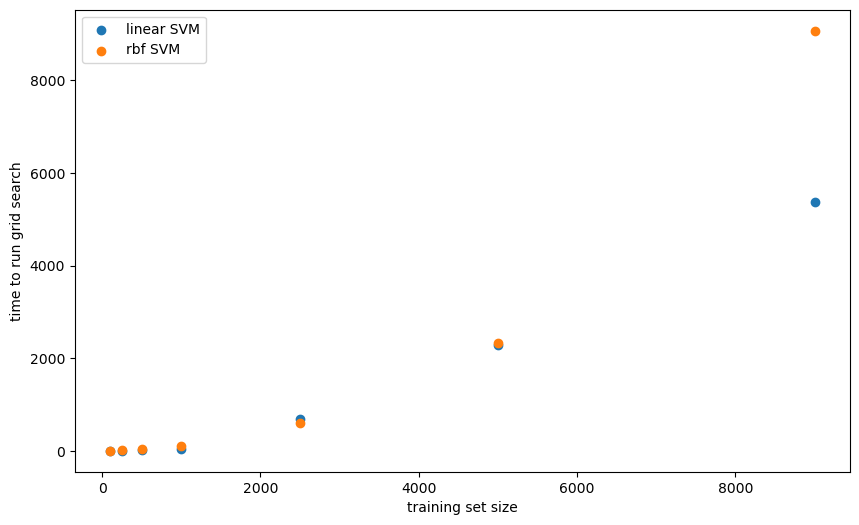

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_3sec, y_3sec, test_size = 0.01, random_state = 1)
sizes = [100, 250, 500, 1000, 2500, 5000, 9000]

linear_runtimes = []
rbf_runtimes = []

X_standard_scaler = StandardScaler().fit(X_train)
X_train = X_standard_scaler.transform(X_train)
for s in sizes:
    start_time = time.time()
    classifier = svm.SVC(C = 10, kernel='linear')
    classifier.fit(X_train[:s], y_train[:s])
    run_time = time.time() - start_time
    linear_runtimes.append(run_time)



for s in sizes:
    start_time = time.time()
    classifier = svm.SVC(C = 10, gamma = .1, kernel='rbf')
    classifier.fit(X_train[:s], y_train[:s])
    run_time = time.time() - start_time
    rbf_runtimes.append(run_time)



np_linear_runtimes = np.array(linear_runtimes)*5*5*5
np_rbf_runtimes = np.array(rbf_runtimes)*5*5*5*5

plt.figure(figsize=(10, 6))
plt.scatter(sizes, np_linear_runtimes, label = 'linear SVM')
plt.scatter(sizes, np_rbf_runtimes, label = 'rbf SVM')
plt.xlabel('training set size')
plt.ylabel('time to run grid search')
plt.legend()
plt.show()

In [22]:
gammas = [.001, .01, 1, 10, 100, 'auto', 'scale']
Cs = [ .01, .1, 1, 10, 100]

rbf_svm_param_grid = [
  {'C': Cs, 
   'gamma': gammas, 
   'kernel': ['rbf']},
 ]
linear_svm_param_grid = [
  {'C': Cs, 
   'kernel': ['linear']},
 ]

print("run csv 30sec")
rbf_svm_csv30sec_best_estimator_c, rbf_svm_csv30sec_best_estimator_gamma, rbf_svm_csv30sec_accuracy, rbf_svm_csv30sec_time = testSVM(
    X_30sec, y_30sec, rbf_svm_param_grid)

print("run csv 30sec norm")
rbf_svm_csv30sec_norm_best_estimator_c, rbf_svm_csv30sec_norm_best_estimator_gamma, rbf_svm_csv30sec_norm_accuracy, rbf_svm_csv30sec_norm_time = testSVM(
    X_30sec_norm, y_30sec, rbf_svm_param_grid)

print("run csv 30sec std")
rbf_svm_csv30sec_std_best_estimator_c, rbf_svm_csv30sec_std_best_estimator_gamma, rbf_svm_csv30sec_std_accuracy, rbf_svm_csv30sec_std_time = testSVM(
    X_30sec_std, y_30sec, rbf_svm_param_grid)

print("run csv 30sec linear")
svm_csv30sec_best_estimator_c, svm_csv30sec_best_estimator_gamma, svm_csv30sec_accuracy, svm_csv30sec_time = testSVM(
    X_30sec, y_30sec, linear_svm_param_grid)

print("run csv 30sec norm linear")
svm_csv30sec_norm_best_estimator_c, svm_csv30sec_norm_best_estimator_gamma, svm_csv30sec_norm_accuracy, svm_csv30sec_norm_time = testSVM(
    X_30sec_norm, y_30sec, linear_svm_param_grid)

print("run csv 30sec std linear")
svm_csv30sec_std_best_estimator_c, svm_csv30sec_std_best_estimator_gamma, svm_csv30sec_std_accuracy, svm_csv30sec_std_time = testSVM(
    X_30sec_std, y_30sec, linear_svm_param_grid)

run csv 30sec
run csv 30sec norm
run csv 30sec std
run csv 30sec linear
run csv 30sec norm linear
run csv 30sec std linear


In [23]:
pd.DataFrame({
    "Dataset": ["Features 30 sec", "Features 30 sec norm", "Features 30 sec std", "Features 30 sec", "Features 30 sec norm", "Features 30 sec std"],
    "Kernal": ["rbf", "rbf", "rbf", "linear", "linear", "linear"],
    "Best C": [
        rbf_svm_csv30sec_best_estimator_c,
        rbf_svm_csv30sec_norm_best_estimator_c,
        rbf_svm_csv30sec_std_best_estimator_c,
        svm_csv30sec_best_estimator_c,
        svm_csv30sec_norm_best_estimator_c,
        svm_csv30sec_std_best_estimator_c
    ],
    "Best gamma": [
        rbf_svm_csv30sec_best_estimator_gamma,
        rbf_svm_csv30sec_norm_best_estimator_gamma,
        rbf_svm_csv30sec_std_best_estimator_gamma,
        'na',  #svm_csv30sec_best_estimator_gamma ,
        'na',  #svm_csv30sec_norm_best_estimator_gamma = 'na',
        'na'   #svm_csv30sec_std_best_estimator_gamma = 'na'
    ],
    "Accuracy": [
        rbf_svm_csv30sec_accuracy,
        rbf_svm_csv30sec_norm_accuracy,
        rbf_svm_csv30sec_std_accuracy,
        svm_csv30sec_accuracy,
        svm_csv30sec_norm_accuracy,
        svm_csv30sec_std_accuracy
    ],
    "Run Time": [
        rbf_svm_csv30sec_time,
        rbf_svm_csv30sec_norm_time,
        rbf_svm_csv30sec_std_time,
        svm_csv30sec_time,
        svm_csv30sec_norm_time,
        svm_csv30sec_std_time
    ]
})

,Dataset,Kernal,Best C,Best gamma,Accuracy,Run Time
0,Features 30 sec,rbf,10.0,0.01,0.750,24.229141
1,Features 30 sec norm,rbf,10.0,0.01,0.750,24.237364
2,Features 30 sec std,rbf,10.0,0.01,0.750,26.819177
3,Features 30 sec,linear,0.1,na,0.725,2.994006
4,Features 30 sec norm,linear,0.1,na,0.725,2.509536
5,Features 30 sec std,linear,0.1,na,0.725,2.398585


## Random Forest 

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def testRandomForest(features, labels, paramgrid):
    
    model = RandomForestClassifier()
    best_estimator, accuracy, run_time = girdSearchClassifier(model, features, labels, paramgrid)
    
    return best_estimator.get_params()['n_estimators'], best_estimator.get_params()['max_depth'], best_estimator.get_params()['bootstrap'], accuracy, run_time

In [25]:
random_forest_param_grid = {
    'n_estimators': [1, 10, 50, 100, 200],
     #'max_features': ['sqrt', 'log2'],
     'max_depth': [10, 20, 30, None],
     #'min_samples_split': [2, 5, 10],
     #'min_samples_leaf': [1, 2, 4],
     'bootstrap': [True, False],
     'n_jobs': [-1]
    
}

print("rf run csv 30sec")
rf_csv30sec_best_estimator_nfeatures, rf_csv30sec_best_estimator_maxdepth, rf_csv30sec_best_estimator_bootstrap, rf_csv30sec_accuracy, rf_csv30sec_time = testRandomForest(
    X_30sec, y_30sec, random_forest_param_grid)

print("rf run csv 30sec norm")
rf_csv30sec_norm_best_estimator_nfeatures, rf_csv30sec_norm_best_estimator_maxdepth, rf_csv30sec_norm_best_estimator_bootstrap, rf_csv30sec_norm_accuracy, rf_csv30sec_norm_time = testRandomForest(
    X_30sec_norm, y_30sec, random_forest_param_grid)

print("rf run csv 30sec std")
rf_csv30sec_std_best_estimator_nfeatures, rf_csv30sec_std_best_estimator_maxdepth, rf_csv30sec_std_best_estimator_bootstrap, rf_csv30sec_std_accuracy, rf_csv30sec_std_time = testRandomForest(
    X_30sec_std, y_30sec, random_forest_param_grid)

print("rf run csv 3sec ")
rf_csv3sec_best_estimator_nfeatures, rf_csv3sec_best_estimator_maxdepth, rf_csv3sec_best_estimator_bootstrap, rf_csv3sec_accuracy, rf_csv3sec_time = testRandomForest(
    X_3sec, y_3sec, random_forest_param_grid)

print("rf run csv 3sec norm ")
rf_csv3sec_norm_best_estimator_nfeatures, rf_csv3sec_norm_best_estimator_maxdepth, rf_csv3sec_norm_best_estimator_bootstrap, rf_csv3sec_norm_accuracy, rf_csv3sec_norm_time = testRandomForest(
    X_3sec_norm, y_3sec, random_forest_param_grid)

print("rf run csv 3sec std")
rf_csv3sec_std_best_estimator_nfeatures, rf_csv3sec_std_best_estimator_maxdepth, rf_csv3sec_std_best_estimator_bootstrap, rf_csv3sec_std_accuracy, rf_csv3sec_std_time = testRandomForest(
    X_3sec_std, y_3sec, random_forest_param_grid)

rf run csv 30sec
rf run csv 30sec norm
rf run csv 30sec std
rf run csv 3sec 
rf run csv 3sec norm 
rf run csv 3sec std


In [26]:
pd.DataFrame({
    "Dataset": ["Features 30 sec", "Features 30 sec norm", "Features 30 sec std", "Features 3 sec", "Features 3 sec norm", "Features 3 sec std"],
    "Best n estimators": [
        rf_csv30sec_best_estimator_nfeatures,
        rf_csv30sec_norm_best_estimator_nfeatures,
        rf_csv30sec_std_best_estimator_nfeatures,
        rf_csv3sec_best_estimator_nfeatures,
        rf_csv3sec_norm_best_estimator_nfeatures,
        rf_csv3sec_std_best_estimator_nfeatures
    ],
    "Best Max Depth": [
        rf_csv30sec_best_estimator_maxdepth,
        rf_csv30sec_norm_best_estimator_maxdepth,
        rf_csv30sec_std_best_estimator_maxdepth,
        rf_csv3sec_best_estimator_maxdepth ,
        rf_csv3sec_norm_best_estimator_maxdepth,
        rf_csv3sec_std_best_estimator_maxdepth
    ],
    "Bootstrap": [
        rf_csv30sec_best_estimator_bootstrap,
        rf_csv30sec_norm_best_estimator_bootstrap,
        rf_csv30sec_std_best_estimator_bootstrap,
        rf_csv3sec_best_estimator_bootstrap,
        rf_csv3sec_norm_best_estimator_bootstrap,
        rf_csv3sec_std_best_estimator_bootstrap
    ],
    "Accuracy": [
        rf_csv30sec_accuracy,
        rf_csv30sec_norm_accuracy,
        rf_csv30sec_std_accuracy,
        rf_csv3sec_accuracy,
        rf_csv3sec_norm_accuracy,
        rf_csv3sec_std_accuracy
    ],
    "Run Time": [
        rf_csv30sec_time,
        rf_csv30sec_norm_time,
        rf_csv30sec_std_time,
        rf_csv3sec_time,
        rf_csv3sec_norm_time,
        rf_csv3sec_std_time
    ]
})

,Dataset,Best n estimators,Best Max Depth,Bootstrap,Accuracy,Run Time
0,Features 30 sec,200,20.0,False,0.722000,75.182219
1,Features 30 sec norm,200,20.0,False,0.718000,74.439369
2,Features 30 sec std,200,30.0,True,0.719000,75.535541
3,Features 3 sec,200,NaN,True,0.874875,349.729891
4,Features 3 sec norm,200,30.0,False,0.898599,359.367730
5,Features 3 sec std,200,20.0,False,0.898098,364.252664


## Convolutional Neural Network

In [27]:
'''TensorFlow setup'''
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorboard.plugins.hparams import api as hp
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
''' 
THIS CELL HAS A LONG RUNTIME
    By using this command I determined that the best optimizer for nearly all amounts of epochs was adamax
    Adamax performed best at 10 epochs
'''
def train_test_cnn(opt,epch):
    model = tf.keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(288, 432, 4)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10),
    ])
    model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    model.fit(X_images_train_tens, y_images_train_tens, epochs=epch)
    _, accuracy = model.evaluate(X_images_val_tens, y_images_val_tens)
    return accuracy

# Convert spectrograms to tensors
X_images_train_tens = tf.convert_to_tensor(X_images_train, dtype=float)
y_images_train_tens = tf.convert_to_tensor(y_images_train.astype(np.float32), dtype=float)
X_images_val_tens = tf.convert_to_tensor(X_images_val, dtype=float)
y_images_val_tens = tf.convert_to_tensor(y_images_val.astype(np.float32), dtype=float)

# Set up cross-validation and choose hyperparameters
OPTIMIZER = ['adam','adamax','ftrl','rmsprop','sgd']
EPOCHS = [5,10,20,30,40]

session_num = 0

for m in allModels:
    m.evaluate(X_images_val_tens,  y_images_val_tens, verbose=2)

In [ ]:
''' 
THIS CELL HAS A LONG RUNTIME
    By using this command I determined that the best optimizer for nearly all amounts of epochs was adamax
    Adamax performed best at 10 epochs
'''
def train_test_cnn(opt,epch):
    model = tf.keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(288, 432, 4)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10),
    ])
    model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    model.fit(X_images_train_tens, y_images_train_tens, epochs=epch)
    _, accuracy = model.evaluate(X_images_val_tens, y_images_val_tens)
    return accuracy

# Convert spectrograms to tensors
X_images_train_tens = tf.convert_to_tensor(X_images_train, dtype=float)
y_images_train_tens = tf.convert_to_tensor(y_images_train.astype(np.float32), dtype=float)
X_images_val_tens = tf.convert_to_tensor(X_images_val, dtype=float)
y_images_val_tens = tf.convert_to_tensor(y_images_val.astype(np.float32), dtype=float)

# Set up cross-validation and choose hyperparameters
OPTIMIZER = ['adam','adamax','ftrl','rmsprop','sgd']
EPOCHS = [5,10,20,30,40]

session_num = 0

outputs = []

for optimizer in OPTIMIZER:
    for epoch in EPOCHS:
        tempAcc = train_test_cnn(optimizer, epoch)
        outputs.append('Trial Number: ' + str(session_num) + 
                        '\nOptimizer: ' + optimizer + 
                        '\nEpochs: ' + str(epoch) +
                        '\nAccuracy: ' + str(tempAcc))
        session_num += 1
    
for result in outputs:
    print(result)

In [30]:
knn_classifier = KNeighborsClassifier(n_neighbors=8)
svm_classifier = svm.SVC(C=10, gamma = .01, kernel="rbf")
rf_classifier = RandomForestClassifier(n_estimators = 200, max_depth = 30, bootstrap = False, n_jobs = -1)
